# Example - Weight Mirroring

March 27, 2022

Weight mirroring is a simple algorithm introduced in "Deep Learning without Weight Transport" (Akrout et al. 2019). 


**The weight transport problem:** Backpropagation is considered biologically implausible for multiple reasons. One reason is the weight transport probklem; namely that during the backward pass of backpropagation, the signal needs to be "transported" backwards via "weights" that are equal to the transpose of the forward pass weights. 

In most of the codebase, I call $W^{out}$ the readout weights, and $W^m$ the internal credit assignment matrix. For backpropagation, $W^m = (W_{out})^\top$

This example shows how weight mirroring can be used to update the matrix $W^m$ (a.k.a the "internal credit assignment matrix"). The general algorithm is as follows:

$$ y'_j = W^{out}_{jk} \cdot \xi_k$$
$$ \Delta W^m \propto \xi_i y'_j  - \lambda W^m$$

where $\xi \sim \mathcal{N}(0,\sigma)$ and $\xi_i y'_j$ is an outer product. With this simple rule, correlations in the "presynaptic" and "postsynaptic" activity push the matrix $W^m$ steadily towards $(W^{out})^\top$. As they argue in the paper, this can be shown by taking the expectation of the update 

$$\mathbb{E}[\xi_i y'_j] = \mathbb{E}[\xi \xi^\top (W^{out})^\top] = \sigma^2 (W^{out})^\top$$

Weight mirroring is implemented in `algorithms.weight_mirror` and requires three additional parameters in `RNNParams`:
* `eta_m`: learning rate of weight mirror rule
* `sig_m`: amount of noise injected in the layer
* `lam_m`: degree of $W^m$ subtraction (not strictly necessary)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.bptt import BPTT
from algorithms.reinforce import REINFORCE
from algorithms.weight_mirror import WeightMirror
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation
from utils.functions import f, df

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.4 # notice here the input duration - this usually makes the task easier

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Compare learning with and without weight mirroring

1. Initialize two networks with "credit assignment matrix" $W^m$ only partially aligned with $W^{out}$
2. Train `net0` with RFLO alone applied to $W^{rec}$
3. Train `net1` with RFLO applied to $W^{rec}$ and weight mirroring applied to $W^m$

We can see from these simulations that `net1` learns faster.

Note that I have slowed down the relative learning rate of the recurrent weights `eta_rec=0.01` to exaggerate the effect of weight mirroring.

4it [00:00, 38.61it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.2
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.01
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
sig_rec_dim: None
eta_m: 0.5
sig_m: 0.1
lam_m: 1e-05
rng: <mtrand.RandomState object at 0x7f9c113585a0>



Alignment of internal model with readout: corr coef=0.245


500it [00:05, 92.48it/s]
9it [00:00, 82.94it/s]


corr coef=0.245


500it [00:05, 95.51it/s]



Alignment after weight mirroring: corr coef=0.985


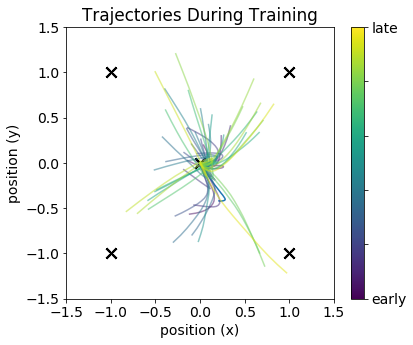

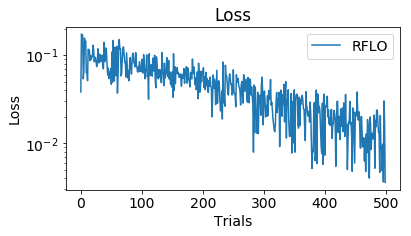

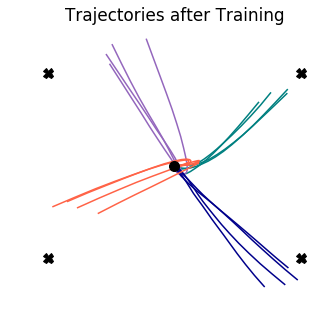

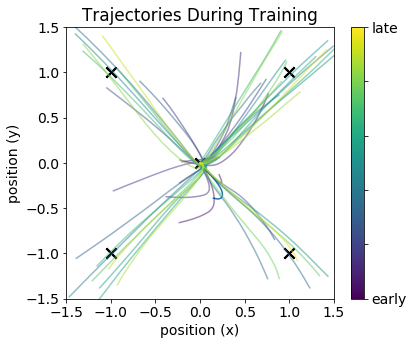

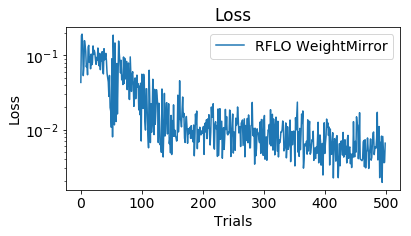

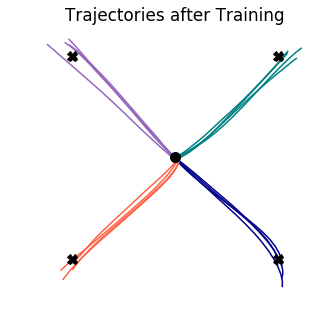

In [16]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.01,eta_out=0.1,eta_fb=0.5, eta_m = 0.5, # note I have slowed down leadning in eta_rec
               sig_in=0.01,sig_rec=0.2,sig_out=0.01, sig_fb=0.01, sig_m = 0.1, lam_m = 0.00001,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=False,
               rng=np.random.RandomState(1))
params.print_params()
print('\n')

# Initialize RNN
net0 = RNN(params,f=f,df=df)
net1 = RNN(params,f=f,df=df)



sig_w_m = 0.5
w_m = np.copy(net0.w_out.T) + sig_w_m*np.random.RandomState(0).randn(net0.w_out.T.shape[0],net0.w_out.T.shape[1]) # keep random value constant

corrcoef = np.corrcoef(w_m.T.ravel(),net0.w_out.ravel())[0,1]
print('\nAlignment of internal model with readout: corr coef={:.3f}'.format(corrcoef))


# initialize simulation
sim0 = Simulation(net0)
sim1 = Simulation(net1)

net0.set_weights(w_m = w_m)
net1.set_weights(w_m = w_m)

""" Simulation without Weight Mirroring (Control) """

rflo = RFLO(net0,apply_to=['w_rec']) 
sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net0.w_m.T.ravel(),net0.w_out.ravel())[0,1]
print('\nNet0 corr coef={:.3f}'.format(corrcoef))

fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

""" Simulation with Weight Mirroring """

rflo = RFLO(net1,apply_to=['w_rec']) 
weight_mirror = WeightMirror(net1,apply_to=['w_m']) 
sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo,weight_mirror], probe_types=['h','y_out','err','pos'], plot=True, plot_freq=10)

corrcoef = np.corrcoef(net1.w_m.T.ravel(),net1.w_out.ravel())[0,1]
print('\nNet1 Alignment after weight mirroring: corr coef={:.3f}'.format(corrcoef))
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])
